<a href="https://colab.research.google.com/github/aghosh92/ELIT_tutorial/blob/main/MD_data_labelled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is prepared by Ayana Ghosh

*A.Ghosh sincerely acknolwedges the contributions of Maxim Ziatdinov, Sergei V. Kalinin, Ondrej Dyck and Bobby G. Sumpter towards materializing this effort.*

## How to construct a training set using data from *simulations*





---


---




1.   It is often the case that we don't have access to enough labelled experimental data for constructing Deep Learning (DL) models.

2.   Data from simulations can be a good starting point in such cases where the experimental conditions (parameters such as temperature etc.) are comparable between the two.


---


3.   In this notebook we learn how to prepare a training set from data generated by *ab-initio* molecular dynamics (MD) of a graphene supercell at 300 K.
4.   A 200 atoms graphene supercell with no added impurities or amorphous parts was utilizied in the simulations. 
5.   For every iteration, one carbon (C) atom was removed and the system was optimized until only few atoms were left in the supercell.
6.   The recorded final positions of the C atoms are then used to prepare the training set.
7.   For simplicity, we will just use four of these positions files (example dataset) to show how it can be done sequentially. 



---


---







For creating augmented dataset corresponding to 2D atomic lattices, we use AtomicImagesSimulator and AtomAI.  
Atoms are represented as 2D Gaussians for every image-label(or mask) pairs.


In [ ]:
#@title Install packages
!git clone https://github.com/ziatdinovmax/AtomicImageSimulator.git
%cd AtomicImageSimulator/

from main import *

!pip install atomai

Cloning into 'AtomicImageSimulator'...
remote: Enumerating objects: 89, done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 89
Unpacking objects: 100% (89/89), done.
/content/AtomicImageSimulator
     |████████████████████████████████| 133kB 13.7MB/s 
     |████████████████████████████████| 194kB 19.3MB/s 
     |████████████████████████████████| 870kB 25.3MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=3c4c39f5e043bcf42c6e3f132bd81f378197e71dc874d056be596ecbabf7e42b
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev


Import essential libraries

In [ ]:
import numpy as np
import os, re
import sys
import pandas as pd
import glob
import matplotlib.pyplot as plt

import atomai as aoi
np.random.seed(0)

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define functions that read in all the position files with coordinates of atoms and generate an augmented dataset (image-labelled masks pair).

In [ ]:
def get_trajectories(filename):
  f = open(filename)
  f_ = f.readlines()
  label_name = filename.split('/')[-1]
  f_s = []
  for l in f_:
      f_s.append(l.strip("\n").strip().split())
  f.close()

  cell = np.array(f_s[2:5], dtype=np.float64)
  n = int(f_s[6][0]) + 1
  traj = {}
  for i in range(7, len(f_s), n):
      coord = np.array(f_s[i + 1 : i + n], dtype=np.float64)
      coord = np.dot(coord, cell)
      traj[int(f_s[i][-1])] = coord
  return traj, label_name


def generate_labelled_mask(local_v, label_name): 
  xy = local_v[:, :2]
  c = np.repeat('C', len(xy))
  lattice_coords = np.concatenate((c[:, None], xy), axis=1)

  # angstrom to pixel conversion coefficient
  ang2px = 10.5
  # angle to rotate coordinates (min, max, step; sampled randomly)
  ang = (0, 180, 5)
  # list with atom "widths" (sampled randomly)
  sc = [13, 15] 
  # blurring due to overlap with a probe
  convprobe = 2.5

  sl = SimulateLattice(lattice_coords, ang2px, ang, sc, convprobe=convprobe)
  img, mask = sl.make_image(r_mask=5)

  _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
  ax1.imshow(img, cmap = 'jet')
  ax2.imshow(mask[..., 0])
  ax1.set_title("Simulated image")
  ax2.set_title("Mask_" + label_name)


def get_labelled_mask(local_v, convprobe=50): 
  xy = local_v[:, :2]
  c = np.repeat('C', len(xy))
  lattice_coords = np.concatenate((c[:, None], xy), axis=1)

  # angstrom to pixel conversion coefficient
  ang2px = 12
  # angle to rotate coordinates (min, max, step; sampled randomly)
  ang = (0, 180, 5)
  # list with atom "widths" (sampled randomly)
  sc = [15, 17, 19] 
  # blurring due to overlap with a probe
  convprobe = convprobe / 10

  sl = SimulateLattice(lattice_coords, ang2px, ang, sc, convprobe=convprobe)
  img, mask = sl.make_image(r_mask=5)

  return img, mask[..., 0]

Download the example MD dataset

In [ ]:
!gdown https://drive.google.com/uc?id=1sT-1bQnSx12krhArS8jbbyukC-RoNNKV
!gdown https://drive.google.com/uc?id=1GZlX0glrjGOt8U_lWCbLuBsj5-PEbLIY
!gdown https://drive.google.com/uc?id=1KAVtmC6V8zRx7-xLz_6nFlVNiOj_VNtF
!gdown https://drive.google.com/uc?id=1bwUhsSPLr_gS314vEKTgSnaChGmj_3aN

Downloading...
From: https://drive.google.com/uc?id=1sT-1bQnSx12krhArS8jbbyukC-RoNNKV
To: /content/AtomicImageSimulator/XDATCAR1
15.2MB [00:00, 70.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GZlX0glrjGOt8U_lWCbLuBsj5-PEbLIY
To: /content/AtomicImageSimulator/XDATCAR2
15.1MB [00:00, 70.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KAVtmC6V8zRx7-xLz_6nFlVNiOj_VNtF
To: /content/AtomicImageSimulator/XDATCAR3
21.2MB [00:00, 80.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bwUhsSPLr_gS314vEKTgSnaChGmj_3aN
To: /content/AtomicImageSimulator/XDATCAR4
15.0MB [00:00, 47.7MB/s]


In [ ]:
filenames = ["XDATCAR1", "XDATCAR2", "XDATCAR3", "XDATCAR4"]

In [ ]:
image_list = []
mask_list = []
label_list = []

#load the list of all files into filenames

filenames = ["XDATCAR1", "XDATCAR2", "XDATCAR3", "XDATCAR4"]

#generate image-mask pairs

for fid in range(0,4):
  print(fid, filenames[fid])
  
  traj, l_name = get_trajectories(filenames[fid])

  local_img_list=[]
  local_mask_list=[]
  for k in range(1,len(traj),30):
    v=traj[k]
    convprobe = np.random.randint(20, 60)
    try:
      c_image, c_mask = get_labelled_mask(v, convprobe)
    except ValueError:
      continue
      
    local_img_list.append(c_image)
    local_mask_list.append(c_mask)

  image_list.append(local_img_list)
  mask_list.append(local_mask_list)
  label_list.append(l_name)

0 XDATCAR1
1 XDATCAR2
2 XDATCAR3
3 XDATCAR4


In [ ]:
print(label_list)

['XDATCAR1', 'XDATCAR2', 'XDATCAR3', 'XDATCAR4']


Text(0.5, 1.0, 'Mask_XDATCAR4')

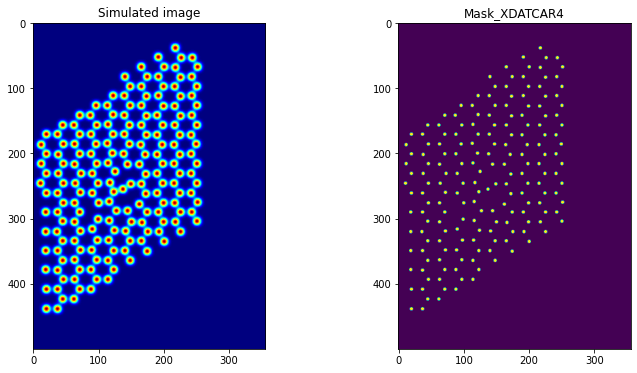

In [ ]:
#plot image from the lists of image-mask pairs

temp_id = 3
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image_list[temp_id][2], cmap = 'jet')
ax2.imshow(mask_list[temp_id][2])
ax1.set_title("Simulated image")
ax2.set_title("Mask_" + label_list[temp_id])

In [ ]:
#crop out the empty spaces

cropped_image_list = []
cropped_mask_list = []

for i in range(0,len(image_list)):
  local_cropped_imglist = []
  local_cropped_masklist = []
  for j in range(0,len(image_list[i])):
    local_cropped_imglist.append(image_list[i][j][80:336,0:256])
    local_cropped_masklist.append(mask_list[i][j][80:336,0:256])

  cropped_image_list.append(local_cropped_imglist)
  cropped_mask_list.append(local_cropped_masklist)

Text(0.5, 1.0, 'Mask_XDATCAR4')

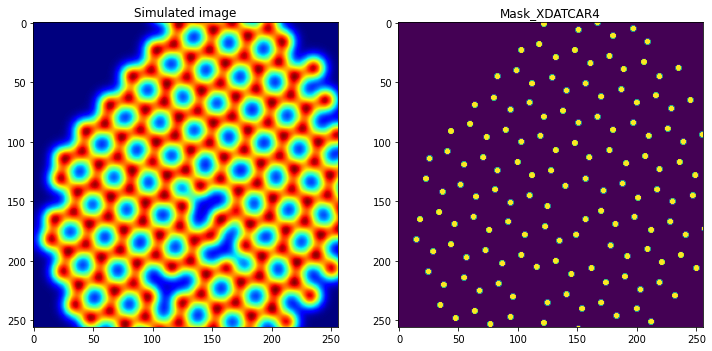

In [ ]:
#plot image from stacked arrays

temp_id = 3
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(cropped_image_list[temp_id][20], cmap = 'jet')
ax2.imshow(cropped_mask_list[temp_id][20])
ax1.set_title("Simulated image")
ax2.set_title("Mask_" + label_list[temp_id])

In [ ]:
#stack them together

images_all = []
masks_all = []
for imlist, masklist in zip(cropped_image_list, cropped_mask_list):
    for im, ma in zip(imlist, masklist):
        if im.shape == (256, 256) and ma.shape == (256, 256):
            images_all.append(im)
            masks_all.append(ma)

images_all = np.array(images_all)
masks_all = np.array(masks_all)

print(images_all.shape, masks_all.shape)

(295, 256, 256) (295, 256, 256)


Augment data so that the trained models can generalize to real experimental data:

In [ ]:
dt = aoi.transforms.datatransform(1, # number of classes
                                  gauss_noise=[2000, 3000], # scaled values
                                  poisson_noise=[30, 45],
                                  blur=False,
                                  contrast=True,
                                  zoom=True,
                                  resize=[2, 1], # downsize all the images by a factor of 2
                                  seed=1)

X_train, y_train = dt.run(images_all, masks_all[..., None])

(-0.5, 207.5, 207.5, -0.5)

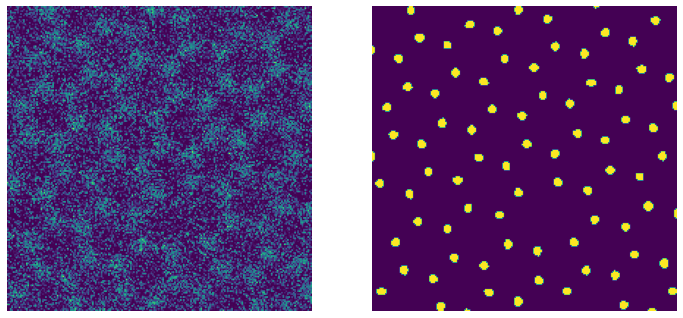

In [ ]:
#visualize the augmented data

k = 200

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(X_train[k,0])
ax2.imshow(y_train[k,0])
ax1.axis('off')
ax2.axis('off')